<a href="https://colab.research.google.com/github/NP-15/Predictive-orders/blob/main/Predictive-orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Making the necessary imports

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

###### Connecting Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


#### Importing datasets

In [ ]:
equipment_orders = pd.read_csv("/content/drive/MyDrive/Machine-Learning-project/equipments.csv")
holidays = pd.read_csv("/content/drive/MyDrive/Machine-Learning-project/holidays.csv")

In [ ]:
equipment_orders.head()

,Date,Equipment
0,2023-01-01,Laser
1,2023-01-02,CaSO4
2,2023-01-04,Optical Spectrometer
3,2023-01-05,Balance Scale
4,2023-01-07,Electron Microscope


In [ ]:
holidays.head()

,Date,Holiday
0,2023-01-01,New Year's Day
1,2023-01-14,Pongal
2,2023-01-15,Makar Sankranti
3,2023-03-11,Maha Shivaratri
4,2023-03-17,Holi


#### Feature extraction

In [ ]:
# Data Preparation
# Convert dates to datetime objects
equipment_orders['Date'] = pd.to_datetime(equipment_orders['Date'])
holidays['Date'] = pd.to_datetime(holidays['Date'])

# Merge datasets on common date column
data = pd.merge(equipment_orders, holidays, how='left', on='Date')

# Calculate duration between consecutive orders for each equipment
data['Duration'] = data.groupby('Equipment')['Date'].diff().dt.days

# Fill missing duration values with mean duration
data['Duration'] = data['Duration'].fillna(data['Duration'].mean())

# Feature Engineering
# Encode categorical variables
data = pd.get_dummies(data, columns=['Holiday'], drop_first=True)

# Shift 'Duration' column to get the duration of next order
data['Next_Order_Duration'] = data.groupby('Equipment')['Duration'].shift(-1)

# Drop rows with NaN values in 'Next_Order_Duration' column
data.dropna(subset=['Next_Order_Duration'], inplace=True)

# Split data into features and target variable
X = data.drop(['Date', 'Equipment', 'Duration', 'Next_Order_Duration'], axis=1)
y = data['Next_Order_Duration']

data.head()

,Date,Equipment,Duration,Holiday_Holi,Holiday_Maha Shivaratri,Holiday_May Day,Holiday_New Year's Day,Holiday_Pongal,Next_Order_Duration
4,2023-01-07,Electron Microscope,74.806452,False,False,False,False,False,121.0
5,2023-01-08,Magnetic Stirrer,74.806452,False,False,False,False,False,104.0
6,2023-01-10,Spectrophotometer,74.806452,False,False,False,False,False,96.0
7,2023-01-11,Petri Dish,74.806452,False,False,False,False,False,89.0
8,2023-01-13,Incubator,74.806452,False,False,False,False,False,96.0


#### Making a Random Forest Model

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Model Evaluation
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 441.4447638899524


#### Making predictions

In [ ]:
# Prediction for next order dates
last_order_date = equipment_orders['Date'].max()
next_order_date = last_order_date + timedelta(days=1)
next_order_features = X.iloc[[-1]].copy()  # Use last row of X as the features for next order prediction

# Check the feature names
print("Feature names:", X_train.columns)

Feature names: Index(['Holiday_Holi', 'Holiday_Maha Shivaratri', 'Holiday_May Day',
       'Holiday_New Year's Day', 'Holiday_Pongal'],
      dtype='object')


In [ ]:
# Add missing columns to next_order_features
missing_cols = set(X_train.columns) - set(next_order_features.columns)
for col in missing_cols:
    next_order_features[col] = 0

# Predict the next order duration
predicted_duration = rf.predict(next_order_features)[0]
predicted_next_order_date = last_order_date + timedelta(days=int(predicted_duration))
print("Predicted Next Order Date:", predicted_next_order_date)

# Predict the next order item
next_order_item = equipment_orders['Equipment'].iloc[-1]  # Assume the last ordered equipment
print("Next Order Item:", next_order_item)

Predicted Next Order Date: 2023-08-02 00:00:00
Next Order Item: Colorimeter


#### Including necessary imports

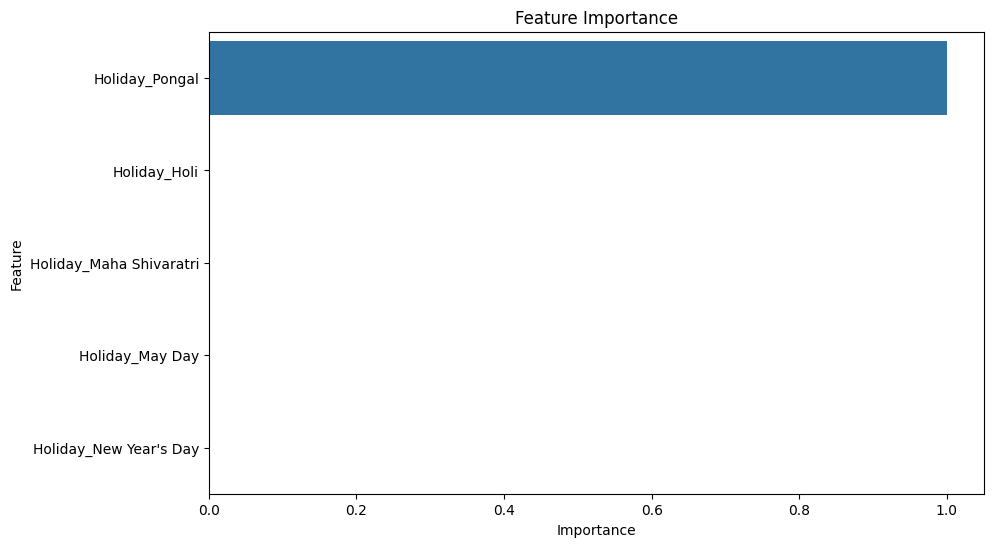

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


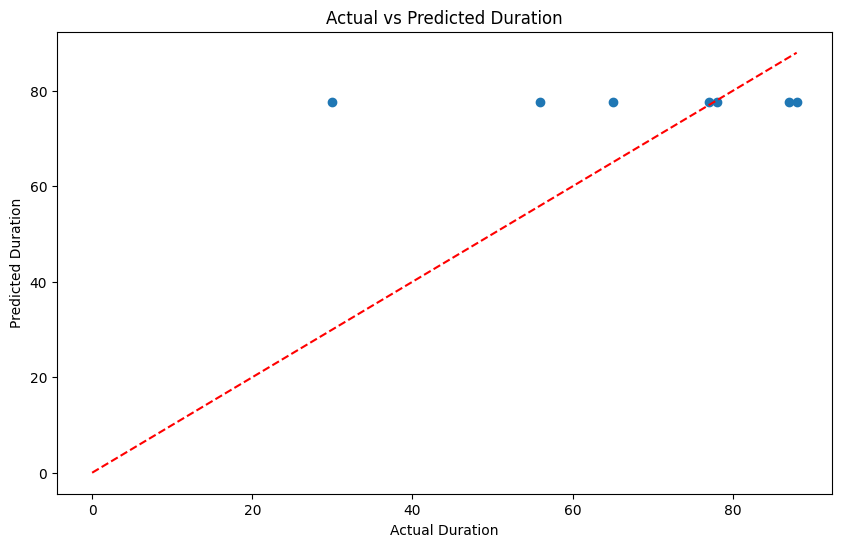

In [ ]:
# Actual vs Predicted Duration
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred, 'o')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.title('Actual vs Predicted Duration')
plt.xlabel('Actual Duration')
plt.ylabel('Predicted Duration')
plt.show()